<a href="https://colab.research.google.com/github/anshupandey/Deep-Learning-for-structured-Data/blob/main/code4_binary_Classification_keras_preprocessing_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Adaption prediction dataset

Reference - https://www.kaggle.com/c/petfinder-adoption-prediction/data

AdoptionSpeed
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
*  0 - Pet was adopted on the same day as it was listed.
*  1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
*  2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
*  3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
*  4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Data Collection and Preparation

In [ ]:
!wget -q 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
!unzip "petfinder-mini.zip"

Archive:  petfinder-mini.zip
replace petfinder-mini/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: petfinder-mini/README.md  
replace __MACOSX/petfinder-mini/._README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/petfinder-mini/._README.md  
replace petfinder-mini/petfinder-mini.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: petfinder-mini/petfinder-mini.csv  
replace __MACOSX/petfinder-mini/._petfinder-mini.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/petfinder-mini/._petfinder-mini.csv  


In [ ]:
#load the dataset
df = pd.read_csv("/content/petfinder-mini/petfinder-mini.csv")
df.shape

(11537, 15)

In [ ]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


Creating a new target variable = "Adapted" representing whether the pet was adopted or not.

for Adoptionspeed=0/1/2/3 = 1, else = 0


In [ ]:
df['Adopted'] = np.where(df['AdoptionSpeed']!=4,1,0)
df.head()

In [ ]:
#check for missing values
df.isnull().sum()

In [ ]:
#check duplicated rows
df.duplicated().sum()

143

In [ ]:
#dropping duplicated rows
df.drop_duplicates(inplace=True)

In [ ]:
# drop unwanted columns
df.drop(columns=['AdoptionSpeed','Description'],inplace=True)

In [ ]:
# check for statistical description
df.describe()

,Age,Fee,PhotoAmt,Adopted
count,10335.000000,10335.000000,10335.000000,10335.000000
mean,12.790711,26.458636,3.721819,0.715723
std,20.093579,84.004002,3.237296,0.451091
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,0.000000
50%,4.000000,0.000000,3.000000,1.000000
75%,12.000000,0.000000,5.000000,1.000000
max,255.000000,2000.000000,30.000000,1.000000


## Splitting data into train, validation and test set

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=6)
train,val = train_test_split(train,test_size=0.2,random_state=6)

print(train.shape,test.shape,val.shape)

(6614, 14) (2067, 14) (1654, 14)


### Creating a data pipelie using tf.data - creating tf.data.dataset

In [ ]:
def create_dataset(df,batch_size):
  df = df.copy()
  target = df.pop('Adopted')
  ds = tf.data.Dataset.from_tensor_slices((dict(df),target))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
train_ds = create_dataset(train,batch_size=10)
[(features,tar)] = train_ds.take(1)

In [ ]:
features

{'Age': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([36,  0,  2, 12,  5,  3, 12, 24,  2, 48])>,
 'Breed1': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'Schnauzer', b'Domestic Medium Hair', b'Mixed Breed', b'Spitz',
        b'Domestic Short Hair', b'Mixed Breed', b'Domestic Short Hair',
        b'Husky', b'Domestic Short Hair', b'Silky Terrier'], dtype=object)>,
 'Color1': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'Black', b'White', b'Cream', b'White', b'Golden', b'Golden',
        b'Brown', b'White', b'Black', b'Black'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'White', b'No Color', b'No Color', b'No Color', b'White',
        b'White', b'White', b'No Color', b'White', b'Brown'], dtype=object)>,
 'Fee': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([300,   0,   0,   0,  50,   0,   0,   0, 150,   0])>,
 'FurLength': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'Medium', b'Medium', b'Short', b'Long', b'Sh

### Normalization

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

def normalization_layer(name,dataset):
  # create a normalization layer
  normalizer = preprocessing.Normalization(axis=None)
  features_ds = dataset.map(lambda x,y:x[name])

  # get the normalization params
  normalizer.adapt(features_ds)
  return normalizer

In [ ]:
age = features['Age']
layer = normalization_layer('Age',train_ds)
layer(age)

### Encoding of categorical attributes

In [ ]:
def encoder_layer(name,dataset,dtype="string",max_tokens=None):
  index = preprocessing.StringLookup(max_tokens=max_tokens)
  feature_ds = dataset.map(lambda x,y:x[name])

  # get the categorical columns
  index.adapt(feature_ds)
  # onehot encoding
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size(),output_mode='one_hot')
  return lambda feature:encoder(index(feature))
  

In [ ]:
breed1 = features['Type']
layer1 = encoder_layer('Type',train_ds,'string')
layer1(breed1)

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [ ]:
batch_size=100
train_ds = create_dataset(train,batch_size=batch_size)
val_ds = create_dataset(val,batch_size=batch_size)
test_ds = create_dataset(test,batch_size=batch_size)

In [ ]:
df.columns

Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt',
       'Adopted'],
      dtype='object')

In [ ]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [ ]:
from tensorflow.keras import layers,models

In [ ]:
# initializing a layer which will carry all preprocessing layer
input_layers = []
encoded_features = []

# passing numeric columns to the input layer
for col in ['Age','Fee','PhotoAmt']:
  numeric_col = layers.Input(shape=(1,),name=col)
  norm_layer = normalization_layer(col,train_ds)
  encoded_num_col = norm_layer(numeric_col)
  input_layers.append(numeric_col)
  encoded_features.append(encoded_num_col)

In [ ]:
# passing categorical columns to the input layer
for col in ['Type','Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize','FurLength', 'Vaccinated', 'Sterilized', 'Health']:
  cat_col = layers.Input(shape=(1,),name=col,dtype='string')
  enc_layer = encoder_layer(col,train_ds,dtype='string')
  encoded_cat_col = enc_layer(cat_col)
  input_layers.append(cat_col)
  encoded_features.append(encoded_cat_col)

In [ ]:
all_features = layers.concatenate(encoded_features)
# add the first dense layer
h1 = layers.Dense(units=10,activation='relu')(all_features)

# more hidden layers
h2 = layers.Dense(units=10,activation='relu')(h1)
h3 = layers.Dense(units=8,activation='relu')(h2)
h4 = layers.Dense(units=6,activation='relu')(h3)
h5 = layers.Dense(units=3,activation='relu')(h4)

# output layer
op = layers.Dense(1,activation='sigmoid')(h5)

model = models.Model(inputs=input_layers,outputs=op)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Type (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color1 (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

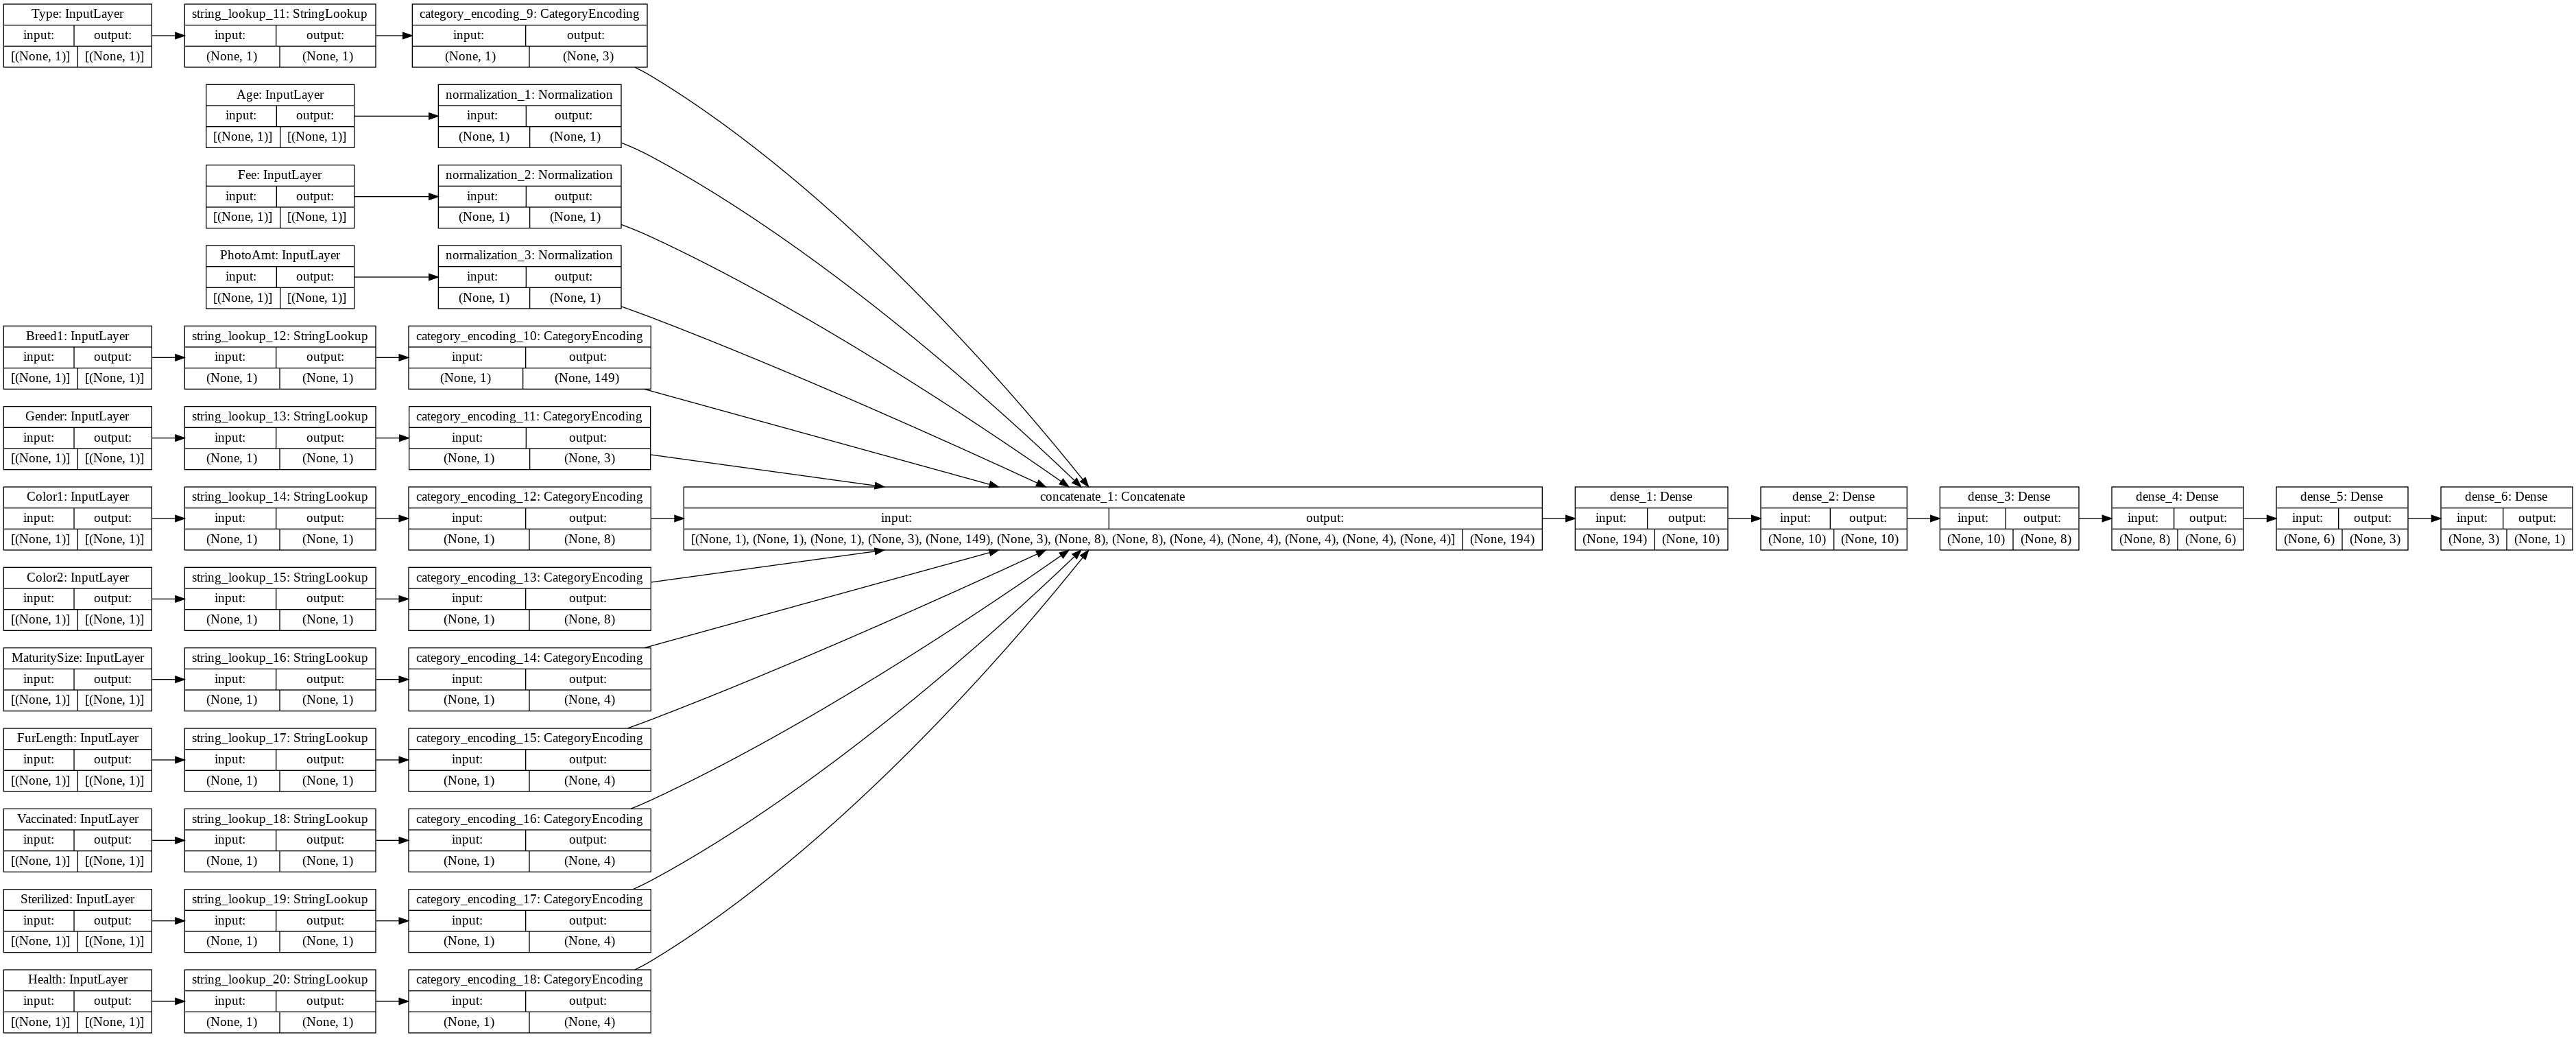

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,rankdir="LR")

In [ ]:
batch_size=1000
train_ds = create_dataset(train,batch_size=batch_size)
val_ds = create_dataset(val,batch_size=batch_size)
test_ds = create_dataset(test,batch_size=batch_size)

In [ ]:
# compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#train the model
model.fit(train_ds,epochs=10,validation_data=val_ds)

In [ ]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 11ms/step - loss: 0.5263 - accuracy: 0.7286


[0.5263102650642395, 0.7285921573638916]

### export the trained model

In [ ]:
model.save("classifier")

INFO:tensorflow:Assets written to: classifier/assets


INFO:tensorflow:Assets written to: classifier/assets


In [ ]:
df.head(1).to_dict()

{'Adopted': {0: 1},
 'Age': {0: 3},
 'Breed1': {0: 'Tabby'},
 'Color1': {0: 'Black'},
 'Color2': {0: 'White'},
 'Fee': {0: 100},
 'FurLength': {0: 'Short'},
 'Gender': {0: 'Male'},
 'Health': {0: 'Healthy'},
 'MaturitySize': {0: 'Small'},
 'PhotoAmt': {0: 1},
 'Sterilized': {0: 'No'},
 'Type': {0: 'Cat'},
 'Vaccinated': {0: 'No'}}

In [ ]:
new_pet = {'Age':3,
 'Breed1':'Tabby',
 'Color1':'Black',
 'Color2':'White',
 'Fee':100,
 'FurLength':'Short',
 'Gender':'Male',
 'Health':'Healthy',
 'MaturitySize':'Small',
 'PhotoAmt':1,
 'Sterilized':'No',
 'Type':'Cat',
 'Vaccinated':'No'}

In [ ]:
new_pet = {key:tf.convert_to_tensor([val]) for key,val in new_pet.items()}
model.predict(new_pet)

array([[0.78473717]], dtype=float32)